# all-MiniLM-L6-v2

In [39]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
# Load and preprocess dataset
df = pd.read_csv("receipts_data_final.csv")
df = df[['item', 'class']].dropna()

# Fix inconsistent labels
category_map = {
    "applicances": "home/appliances",
    "home": "home/appliances",
    "transportation": "transport",
    "entertainment/alcohol": "alcohol/entertainment"
}
df["class"] = df["class"].str.lower().replace(category_map)

# Encode labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["class"])

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    df["item"].tolist(), df["label"].tolist(),
    test_size=0.2, stratify=df["label"], random_state=42
)

# Load pretrained MiniLM
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [41]:
# Custom Dataset
class ReceiptDataset(Dataset):
    def __init__(self, texts, labels):
        self.embeddings = embedding_model.encode(texts, convert_to_tensor=True)
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

train_loader = DataLoader(ReceiptDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(ReceiptDataset(X_val, y_val), batch_size=16)

# Define classifier model
class MiniLMClassifier(nn.Module):
    def __init__(self, input_dim=384, hidden_dim=128, output_dim=6):
        super(MiniLMClassifier, self).__init__()
        self.name = f"MiniLM_FC{input_dim}-{hidden_dim}-{output_dim}"
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.classifier(x)

In [42]:
# Training and evaluation utilities
def get_model_name(name, learning_rate, epoch):
    return f"model_{name}_lr{learning_rate}_epoch{epoch}"

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(train_loader), correct / total

def get_accuracy(model, loader):
    correct, total = 0, 0
    device = next(model.parameters()).device
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def evaluate(model, loader, criterion):
    device = next(model.parameters()).device
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(loader), get_accuracy(model, loader)

def save_model(model, save_dir, learning_rate, epoch):
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        model_name = get_model_name(model.name, learning_rate, epoch)
        model_path = os.path.join(save_dir, f"{model_name}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Model saved: {model_path}")

def plot_results(train_losses, valid_losses, train_accuracies, valid_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(valid_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(valid_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.show()

In [44]:
def train_model(model, train_loader, valid_loader, num_epochs=10, learning_rate=1e-4, device="cuda", save_dir="./checkpoints"):
    if device == "cuda" and not torch.cuda.is_available():
        print("CUDA is not available. Switching to CPU.")
        device = "cpu"
    print(f"Using device: {device}")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, valid_loader, criterion)

        train_losses.append(train_loss)
        valid_losses.append(val_loss)
        train_accuracies.append(train_acc)
        valid_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] → Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        save_model(model, save_dir, learning_rate, epoch+1)

    plot_results(train_losses, valid_losses, train_accuracies, valid_accuracies)

    return {
        "train_losses": train_losses,
        "valid_losses": valid_losses,
        "train_accuracies": train_accuracies,
        "valid_accuracies": valid_accuracies
    }

Using device: cuda
Epoch [1/10] → Train Loss: 1.7989, Acc: 0.0086 | Val Loss: 1.7880, Acc: 0.0115
Model saved: ./checkpoints\model_MiniLM_FC384-128-6_lr0.0001_epoch1.pth
Epoch [2/10] → Train Loss: 1.7744, Acc: 0.0519 | Val Loss: 1.7628, Acc: 0.2759
Model saved: ./checkpoints\model_MiniLM_FC384-128-6_lr0.0001_epoch2.pth
Epoch [3/10] → Train Loss: 1.7471, Acc: 0.4524 | Val Loss: 1.7342, Acc: 0.6207
Model saved: ./checkpoints\model_MiniLM_FC384-128-6_lr0.0001_epoch3.pth
Epoch [4/10] → Train Loss: 1.7154, Acc: 0.6023 | Val Loss: 1.7003, Acc: 0.5977
Model saved: ./checkpoints\model_MiniLM_FC384-128-6_lr0.0001_epoch4.pth
Epoch [5/10] → Train Loss: 1.6775, Acc: 0.5735 | Val Loss: 1.6602, Acc: 0.5517
Model saved: ./checkpoints\model_MiniLM_FC384-128-6_lr0.0001_epoch5.pth
Epoch [6/10] → Train Loss: 1.6351, Acc: 0.5706 | Val Loss: 1.6133, Acc: 0.5517
Model saved: ./checkpoints\model_MiniLM_FC384-128-6_lr0.0001_epoch6.pth
Epoch [7/10] → Train Loss: 1.5835, Acc: 0.5648 | Val Loss: 1.5595, Acc: 0.5

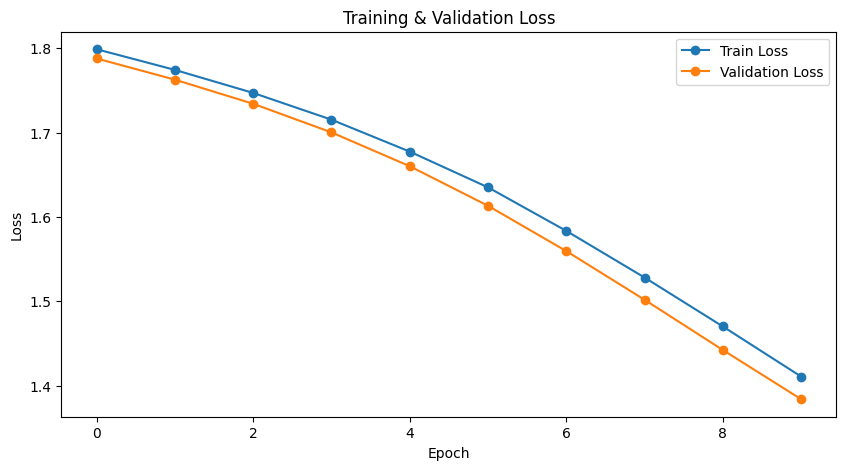

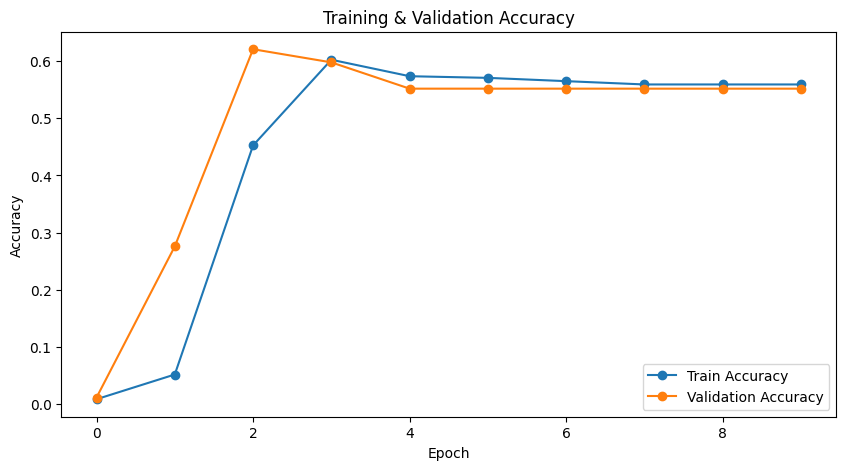

In [45]:
model = MiniLMClassifier(output_dim=len(label_encoder.classes_))
results = train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4)

In [2]:
import pandas as pd

# Load your dataset
df = pd.read_csv("receipts_data_final.csv")

# Clean up inconsistent labels
category_map = {
    "applicances": "home/appliances",
    "home": "home/appliances",
    "transportation": "transport",
    "entertainment/alcohol": "alcohol/entertainment"
}
df["class"] = df["class"].str.lower().replace(category_map)

# Print class distribution
class_counts = df["class"].value_counts()
print("Class Distribution:\n")
print(class_counts)


Class Distribution:

class
food                     239
home/appliances          101
other                     80
alcohol/entertainment      5
clothing                   5
transport                  4
Name: count, dtype: int64
